In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:
pixel_size = 4  # 4 mm x 4 mm pixels
grid_size = 12   # 12x12 events

## Download data

In [ ]:
!mkdir data

# CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX_2
!cd data && wget -O monolithic_csi_CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX_2.tar.gz https://www.dropbox.com/scl/fi/p8h1jmp3flzofvipaxbqm/monolithic_csi_CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX_2.tar.gz?rlkey=wywymsocrbnhaju2ptq18lnnh&dl=0
!cd data && tar -xvf monolithic_csi_CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX_2.tar.gz
!cd data && mv CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX_2/* .

# BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX
# !cd data && wget -O monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX.tar.gz https://www.dropbox.com/scl/fi/mfc3w8m9iqd7es8x2duht/monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX.tar.gz?rlkey=eme010vg5ghxukqlc15t2vogw&dl=0
# !cd data && tar -xvf monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX.tar.gz
# !cd data && mv BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX/* .

## Look at a few events

In [3]:
imgs = np.load("data/images_1.npy")
mdata = pd.read_csv("data/metadata_1.csv")

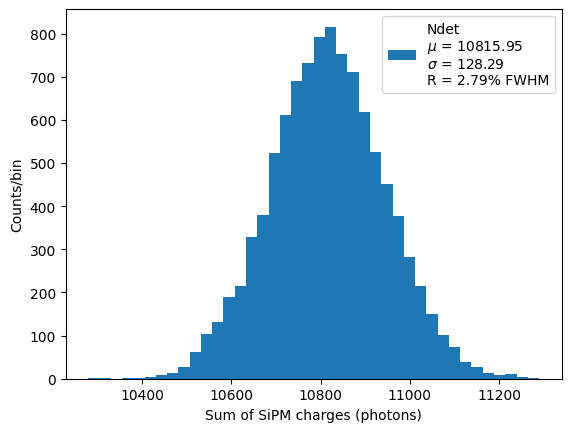

In [4]:
# Sum of SiPM charges
ndet = np.sum(imgs,axis=(1,2))
plt.hist(ndet,bins=40,label=f"Ndet\n$\mu$ = {np.mean(ndet):.2f}\n$\sigma$ = {np.std(ndet):.2f}\nR = {235*np.std(ndet)/np.mean(ndet):.2f}% FWHM")
plt.xlabel("Sum of SiPM charges (photons)")
plt.ylabel("Counts/bin")
plt.legend()

Text(0.5, 1.0, '48939 photons')

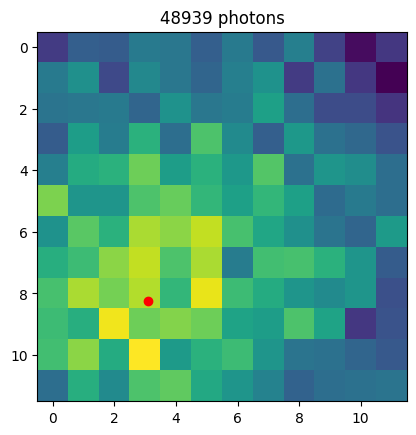

In [5]:
# Pick an event to plot.
ev = 12

# Show the image.
plt.imshow(imgs[ev,:,:])

# Show the event location.
x_evt = (mdata['initial_y'][ev] + pixel_size*grid_size/2)/pixel_size - 0.5
y_evt = (mdata['initial_x'][ev] + pixel_size*grid_size/2)/pixel_size - 0.5
plt.plot([x_evt],[y_evt],'o',color='red')
plt.title(f"{mdata['n_photons'][ev]} photons")

## Set up weights for the weighted MSE loss

In [6]:
# Set up weights based on data value ranges
w_xpos  = 1./(mdata['initial_x'].max() - mdata['initial_x'].min())
w_ypos  = 1./(mdata['initial_y'].max() - mdata['initial_y'].min())
w_zpos  = 1./(mdata['initial_z'].max() - mdata['initial_z'].min())
w_nphot = 1./(mdata['n_photons'].max() - mdata['n_photons'].min())
wnorm = w_xpos + w_ypos + w_zpos + w_nphot
loss_weights = torch.tensor([w_xpos/wnorm, w_ypos/wnorm, w_zpos/wnorm, w_nphot/wnorm])
print(f"Weights are: {loss_weights}")
#print(f"Weights are (w_x,w_y,w_z,w_N) = ({w_xpos},{w_ypos},{w_zpos},{w_nphot})")

Weights are: tensor([3.8431e-02, 3.8422e-02, 9.2246e-01, 6.8197e-04], dtype=torch.float64)


---

## Position prediction with a neural network

#### The NN class

In [7]:
# Basic CNN for (x,y,z) prediction

chi = 128        # initial number of channels (increase to make net larger)
netdebug = False  # print debugging information for net

class CNN_basic(nn.Module):
    def __init__(self):
        super(CNN_basic, self).__init__()

        self.conv1 = nn.Conv2d(1, chi, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.pool = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.fc0 = nn.Linear(chi*4, 4)
        self.drop1 = nn.Dropout(p=0.2)

        # Initialize weights
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

    def forward(self, x):

        if(netdebug): print(x.shape)
        x = self.pool3(self.bn1(F.leaky_relu(self.conv1(x))))
        if(netdebug): print(x.shape)
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        if(netdebug): print(x.shape)
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        if(netdebug): print(x.shape)
        x = x.flatten(start_dim=1)
        if(netdebug): print(x.shape)
        #x = self.drop1(x)
        x = self.fc0(x)
        if(netdebug): print(x.shape)

        return x

#### The dataset class

In [8]:
class SiPMDataset(Dataset):

    def __init__(self, data_path, total_files):
        self.data_path = data_path
        self.total_files = total_files
        self.dataset = []

        for i in range(self.total_files):
            #images = np.load(f'{self.data_path}/images_{i:02}.npy')
            images = np.load(f'{self.data_path}/images_{i+50}.npy')
            #metadata = pd.read_csv(f'{self.data_path}/metadata_{i:02}.csv')
            metadata = pd.read_csv(f'{self.data_path}/metadata_{i+50}.csv')

            for img, meta in zip(images, metadata.values):
                self.dataset.append((img, meta[1:]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, position = self.dataset[idx]
        image = torch.tensor(image, dtype=torch.float).unsqueeze(0) # Add channel dimension
        position = torch.tensor(position[0:4], dtype=torch.float)

        return image, position

#### Load the data

In [9]:
# Load the data
data_path = 'data'
total_files = 20  # Number of files to use
batch_size = 1000  # Batch size

dataset = SiPMDataset(data_path, total_files)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
ntot_evts = len(dataset)
print(f"Loaded {len(dataset)} events")

# Split the data into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # training
val_size = int(0.2 * len(dataset))    # validation
test_size = len(dataset) - train_size - val_size  # test
train_indices = range(train_size)
val_indices = range(train_size, train_size + val_size)
test_indices = range(train_size + val_size, len(dataset))

# Define subsets of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_indices)
print(f"{len(train_dataset)} training events ({100*len(train_dataset)/ntot_evts}%)")
val_dataset = torch.utils.data.Subset(dataset, val_indices)
print(f"{len(val_dataset)} validation events ({100*len(val_dataset)/ntot_evts}%)")
test_dataset = torch.utils.data.Subset(dataset, test_indices)
print(f"{len(test_dataset)} test events ({100*len(test_dataset)/ntot_evts}%)")

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loaded 200000 events
140000 training events (70.0%)
40000 validation events (20.0%)
20000 test events (10.0%)


#### Train the network

In [10]:
# Define a weighted MSE loss function
def weighted_mse_loss(outputs, targets, weights):
    """
    Compute the weighted MSE loss.

    Parameters:
    - outputs: tensor of model predictions.
    - targets: tensor of target values.
    - weights: tensor of weights for each component of the loss.

    Returns:
    - Weighted MSE loss.
    """
    # Ensure weights are on the same device as outputs and targets
    if torch.cuda.is_available():
        weights = weights.cuda()

    # Calculate the squared differences
    squared_diffs = (outputs - targets) ** 2

    # Apply weights
    weighted_squared_diffs = weights * squared_diffs

    # Return the mean of the weighted squared differences
    return weighted_squared_diffs.mean()

In [11]:
# Load the model.
model = CNN_basic()
if torch.cuda.is_available():
    model = model.cuda()

# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.MSELoss()  # old loss with no weighting

# Print a model summary
summary(model, (1, 12, 12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 12, 12]           1,280
       BatchNorm2d-2          [-1, 128, 12, 12]             256
         MaxPool2d-3            [-1, 128, 4, 4]               0
            Conv2d-4            [-1, 256, 5, 5]         131,328
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         MaxPool2d-6            [-1, 256, 2, 2]               0
            Conv2d-7            [-1, 512, 3, 3]         524,800
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10                    [-1, 4]           2,052
Total params: 661,252
Trainable params: 661,252
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 2.52
Estimated T

In [16]:
# Training loop
epochs = 20
train_losses, val_losses = [], []
for epoch in range(epochs):

    train_losses_epoch, val_losses_epoch = [], []

    print(f"\nEPOCH {epoch}")

    # Training step
    for i, (images, positions) in enumerate(train_loader):

        if torch.cuda.is_available():
           images = images.cuda()
           positions = positions.cuda()

        model.train()
        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_mse_loss(outputs,positions,loss_weights) #criterion(outputs, positions)
        loss.backward()
        optimizer.step()
        train_losses_epoch.append(loss.data.item())
        if((i+1) % (len(train_loader)/10) == 0):
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")

    # Validation step
    with torch.no_grad():
        model.eval()
        for i, (images, positions) in enumerate(val_loader):

            if torch.cuda.is_available():
              images = images.cuda()
              positions = positions.cuda()

            outputs = model(images)
            loss = weighted_mse_loss(outputs,positions,loss_weights) #criterion(outputs, positions)
            val_losses_epoch.append(loss.data.item())
            if((i+1) % (len(val_loader)/10) == 0):
              print(f"Validation Step {i + 1}/{len(val_loader)}, Loss: {loss.data.item()}")


    train_losses.append(np.mean(train_losses_epoch))
    val_losses.append(np.mean(val_losses_epoch))
    print(f"--- EPOCH {epoch} AVG TRAIN LOSS: {np.mean(train_losses_epoch)}")
    print(f"--- EPOCH {epoch} AVG VAL LOSS: {np.mean(val_losses_epoch)}")


EPOCH 0
Train Step 14/140, Loss: 225.45451908785077
Train Step 28/140, Loss: 208.4573090129082
Train Step 42/140, Loss: 194.1224379598053
Train Step 56/140, Loss: 181.6042180219246
Train Step 70/140, Loss: 172.415849717827
Train Step 84/140, Loss: 159.75391740621765
Train Step 98/140, Loss: 152.78438272385216
Train Step 112/140, Loss: 150.25481121994275
Train Step 126/140, Loss: 136.34374896846296
Train Step 140/140, Loss: 129.16793705939966
Validation Step 4/40, Loss: 118.19839090451374
Validation Step 8/40, Loss: 121.47941951401323
Validation Step 12/40, Loss: 119.97822050982938
Validation Step 16/40, Loss: 121.48120458497073
Validation Step 20/40, Loss: 125.86487428783168
Validation Step 24/40, Loss: 119.16495094910445
Validation Step 28/40, Loss: 118.94636383112535
Validation Step 32/40, Loss: 121.48279505739822
Validation Step 36/40, Loss: 119.52091857598974
Validation Step 40/40, Loss: 119.7311220044074
--- EPOCH 0 AVG TRAIN LOSS: 176.3020165860994
--- EPOCH 0 AVG VAL LOSS: 120.

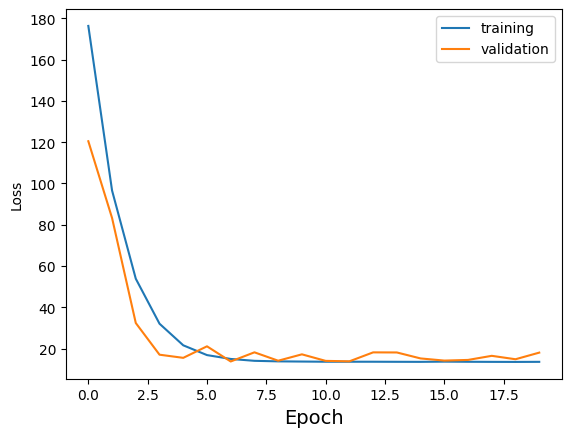

In [17]:
# Plot training and validation loss
xvals_train = np.arange(0,epochs,1)
xvals_val = np.arange(0,epochs,1)
plt.plot(xvals_train,train_losses,label='training')
plt.plot(xvals_val,val_losses,label='validation')
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss")
plt.legend()

#### Evaluate the network

In [18]:
def weighted_mean_and_sigma(image):

    # Total intensity of the image
    total_intensity = np.sum(image)

    # Indices for x and y (make (0,0) the center of the 8x8 grid)
    y_indices, x_indices = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    y_indices = np.array(y_indices) - 3.5
    x_indices = np.array(x_indices) - 3.5

    # Weighted means
    weighted_mean_x = np.sum(x_indices * image) / total_intensity
    weighted_mean_y = np.sum(y_indices * image) / total_intensity

    # Weighted standard deviations
    weighted_sigma_x = np.sqrt(np.sum(image * (x_indices - weighted_mean_x)**2) / total_intensity)
    weighted_sigma_y = np.sqrt(np.sum(image * (y_indices - weighted_mean_y)**2) / total_intensity)

    return weighted_mean_x, weighted_mean_y, weighted_sigma_x, weighted_sigma_y

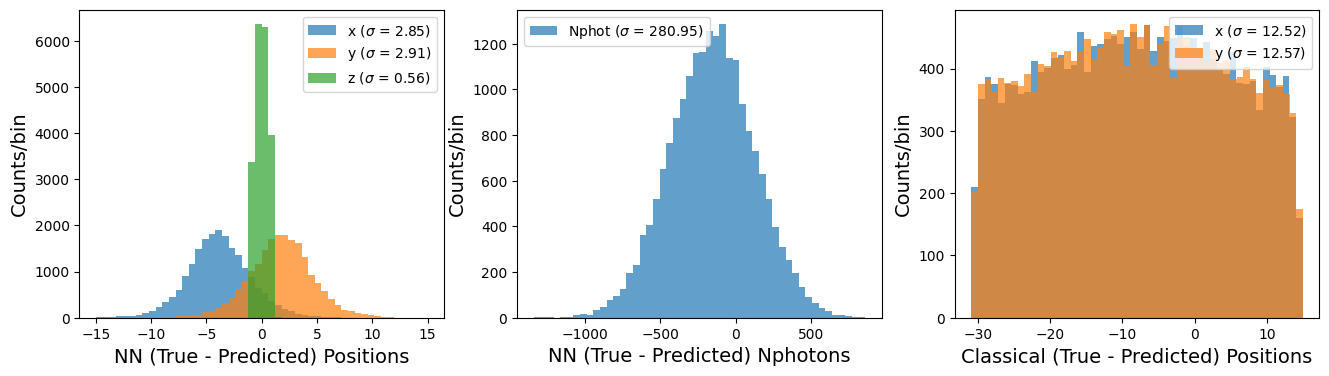

In [23]:
# Evaluate the test set.
true_x, true_y, true_z, true_N = [],[],[], []
mean_x, mean_y = [],[]
sigma_x, sigma_y = [],[]
predicted_x, predicted_y, predicted_z, predicted_N = [],[],[],[]
with torch.no_grad():

    model.eval()
    for i, (images, positions) in enumerate(test_loader):

        if torch.cuda.is_available():
            images = images.cuda()

        outputs = model(images).cpu()

        for x in positions[:,0]: true_x.append(x)
        for y in positions[:,1]: true_y.append(y)
        for z in positions[:,2]: true_z.append(z)
        for N in positions[:,3]: true_N.append(N)

        for x in outputs[:,0]: predicted_x.append(x)
        for y in outputs[:,1]: predicted_y.append(y)
        for z in outputs[:,2]: predicted_z.append(z)
        for N in outputs[:,3]: predicted_N.append(N)

        for img in images.cpu().squeeze().numpy():
            mu_x, mu_y, sd_x, sd_y = weighted_mean_and_sigma(img)
            mean_x.append(mu_x); mean_y.append(mu_y)
            sigma_x.append(sd_x); sigma_y.append(sd_y)

# Convert to numpy arrays
true_x = np.array(true_x); true_y = np.array(true_y); true_z = np.array(true_z); true_N = np.array(true_N)
predicted_x = np.array(predicted_x); predicted_y = np.array(predicted_y); predicted_z = np.array(predicted_z); predicted_N = np.array(predicted_N)
mean_x = np.array(mean_x); mean_y = np.array(mean_y)
sigma_x = np.array(sigma_x); sigma_y = np.array(sigma_y)

# Compute deltas for the NN.
delta_x_NN = true_x - predicted_x
delta_y_NN = true_y - predicted_y
delta_z_NN = true_z - predicted_z
delta_N_NN = true_N - predicted_N

# Compute deltas for the classical method
delta_x_classical = true_x - pixel_size*mean_x
delta_y_classical = true_y - pixel_size*mean_y

# Histograms of (true - predicted) for x, y, and z
nbins = 50

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
flat_axes = axes.ravel()
ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]

ax0.hist(delta_x_NN, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_NN):.2f})", alpha=0.7, range=[-15,15])
ax0.hist(delta_y_NN, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_NN):.2f})", alpha=0.7, range=[-15,15])
ax0.hist(delta_z_NN, bins=nbins, label=f"z ($\sigma$ = {np.std(delta_z_NN):.2f})", alpha=0.7, range=[-15,15])
ax0.set_xlabel("NN (True - Predicted) Positions",fontsize=14)
ax0.set_ylabel("Counts/bin",fontsize=14)
ax0.legend()

ax1.hist(delta_N_NN, bins=nbins, label=f"Nphot ($\sigma$ = {np.std(delta_N_NN):.2f})", alpha=0.7)
ax1.set_xlabel("NN (True - Predicted) Nphotons",fontsize=14)
ax1.set_ylabel("Counts/bin",fontsize=14)
ax1.legend()

ax2.hist(delta_x_classical, bins=nbins, label=f"x ($\sigma$ = {np.std(delta_x_classical):.2f})", alpha=0.7)
ax2.hist(delta_y_classical, bins=nbins, label=f"y ($\sigma$ = {np.std(delta_y_classical):.2f})", alpha=0.7)
ax2.set_xlabel("Classical (True - Predicted) Positions",fontsize=14)
ax2.set_ylabel("Counts/bin",fontsize=14)
ax2.legend()

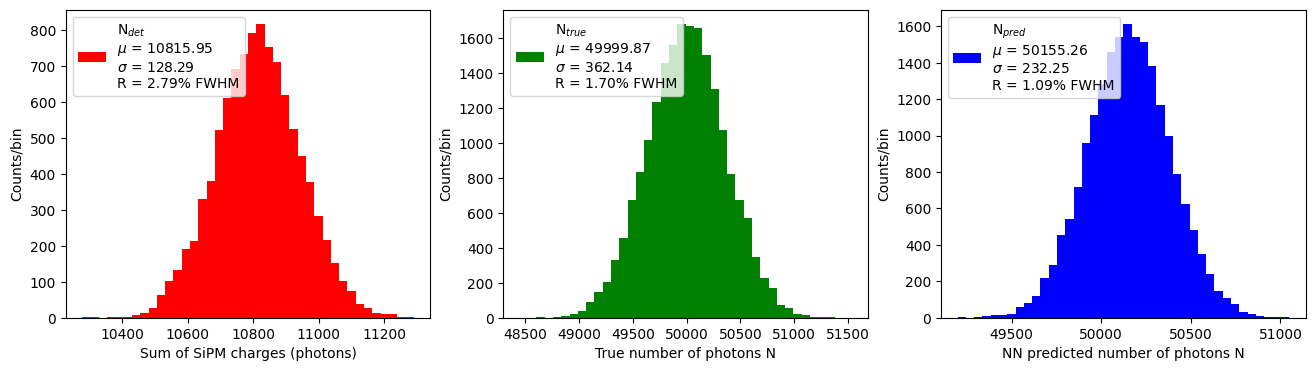

In [24]:
# Evaluate the energy resolution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
flat_axes = axes.ravel()
ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]

ndet = np.sum(imgs,axis=(1,2))
ax0.hist(ndet,bins=40,label=f"N$_{{det}}$\n$\mu$ = {np.mean(ndet):.2f}\n$\sigma$ = {np.std(ndet):.2f}\nR = {235*np.std(ndet)/np.mean(ndet):.2f}% FWHM",color='red')
ax0.set_xlabel("Sum of SiPM charges (photons)")
ax0.set_ylabel("Counts/bin")
#ax0.set_title("Detected")
ax0.legend()

ax1.hist(true_N,bins=40,label=f"N$_{{true}}$\n$\mu$ = {np.mean(true_N):.2f}\n$\sigma$ = {np.std(true_N):.2f}\nR = {235*np.std(true_N)/np.mean(true_N):.2f}% FWHM",color='green')
ax1.set_xlabel("True number of photons N")
ax1.set_ylabel("Counts/bin")
#ax1.set_title("True")
ax1.legend()

ax2.hist(predicted_N,bins=40,label=f"N$_{{pred}}$\n$\mu$ = {np.mean(predicted_N):.2f}\n$\sigma$ = {np.std(predicted_N):.2f}\nR = {235*np.std(predicted_N)/np.mean(predicted_N):.2f}% FWHM",color='blue')
ax2.set_xlabel("NN predicted number of photons N")
ax2.set_ylabel("Counts/bin")
#ax2.set_title("Predicted")
ax2.legend()

In [ ]:
np.savez("data_monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_NX.npz", delta_x_NN=delta_x_NN, delta_y_NN=delta_y_NN, delta_z_NN=delta_z_NN, delta_x_classical=delta_x_classical, delta_y_classical=delta_y_classical, true_x=true_x, true_y=true_y, true_z=true_z, predicted_x_NN=predicted_x, predicted_y_NN=predicted_y, predicted_z_NN=predicted_z, predicted_x_classical=pixel_size*mean_x, predicted_y_classical=pixel_size*mean_y)

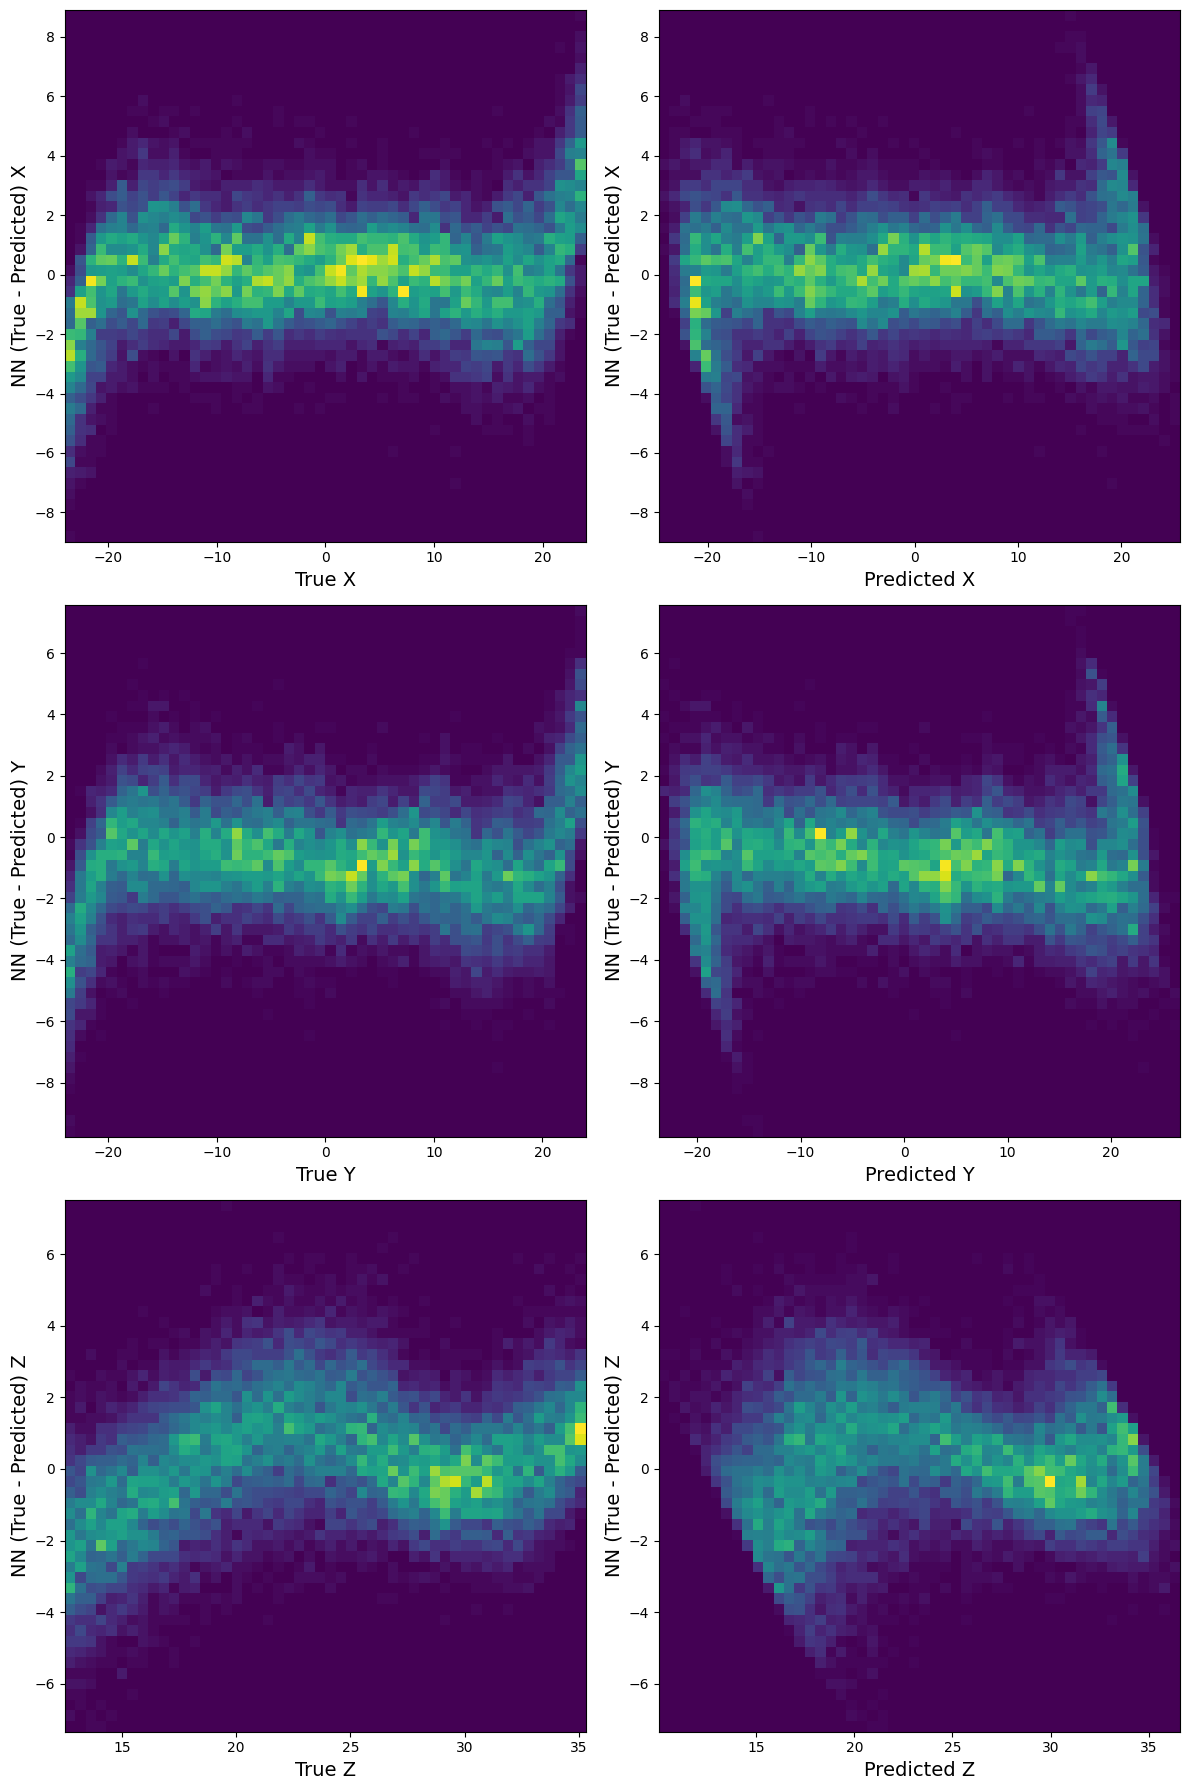

In [ ]:
nbins = 50

# Create figure and axes
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Delta vs. True Values
axes[0, 0].hist2d(true_x, delta_x_NN, bins=nbins, cmap='viridis')
axes[0, 0].set_xlabel('True X',fontsize=14)
axes[0, 0].set_ylabel('NN (True - Predicted) X',fontsize=14)
#axes[0, 0].set_title('NN (True - Predicted) X vs. True X',fontsize=14)

axes[1, 0].hist2d(true_y, delta_y_NN, bins=nbins, cmap='viridis')
axes[1, 0].set_xlabel('True Y',fontsize=14)
axes[1, 0].set_ylabel('NN (True - Predicted) Y',fontsize=14)
#axes[1, 0].set_title('NN (True - Predicted) Y vs. True Y',fontsize=14)

axes[2, 0].hist2d(true_z, delta_z_NN, bins=nbins, cmap='viridis')
axes[2, 0].set_xlabel('True Z',fontsize=14)
axes[2, 0].set_ylabel('NN (True - Predicted) Z',fontsize=14)
#axes[2, 0].set_title('NN (True - Predicted) Z vs. True Z',fontsize=14)

# Delta vs. Predicted Values
axes[0, 1].hist2d(predicted_x, delta_x_NN, bins=nbins, cmap='viridis')
axes[0, 1].set_xlabel('Predicted X',fontsize=14)
axes[0, 1].set_ylabel('NN (True - Predicted) X',fontsize=14)
#axes[0, 1].set_title('NN (True - Predicted) X vs. Predicted X',fontsize=14)

axes[1, 1].hist2d(predicted_y, delta_y_NN, bins=nbins, cmap='viridis')
axes[1, 1].set_xlabel('Predicted Y',fontsize=14)
axes[1, 1].set_ylabel('NN (True - Predicted) Y',fontsize=14)
#axes[1, 1].set_title('NN (True - Predicted) Y vs. Predicted Y',fontsize=14)

axes[2, 1].hist2d(predicted_z, delta_z_NN, bins=nbins, cmap='viridis')
axes[2, 1].set_xlabel('Predicted Z',fontsize=14)
axes[2, 1].set_ylabel('NN (True - Predicted) Z',fontsize=14)
#axes[2, 1].set_title('NN (True - Predicted) Z vs. Predicted Z',fontsize=14)

# Adjust layout for better fit
plt.tight_layout()
plt.show()

### Additional datasets

In [ ]:
# CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_fano_NX
# !cd data && wget -O monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_fano_NX.tar.gz https://www.dropbox.com/s/aim7gouq60a72gj/monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_fano_NX.tar.gz?dl=0
# !cd data && tar -xvf monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_fano_NX.tar.gz
# !cd data && mv CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_fano_NX/* .

# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/d9kdfqnacoegq4lt12qnk/monolithic_csi_CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUTDAVIS_NX.tar.gz?rlkey=y04a6punw43zlsoo0lcrqd4mf&dl=0
# !cd data && tar -xvf monolithic_csi_CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUTDAVIS_NX.tar.gz
# !cd data && mv CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUTDAVIS_NX/* .

# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX
# !cd data && wget -O monolithic_csi_CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/jldgtl4m1lh78rbh2j8n4/monolithic_csi_CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX.tar.gz?rlkey=u7cj39yci9ih8d0hgx4zl8m3u&dl=0
# !cd data && tar -xvf monolithic_csi_CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX.tar.gz
# !cd data && mv CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX/* .

# LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/zi9vahivbc1orldl1l86u/monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz?rlkey=3knl94arb5o8uwgvh0th5228u&dl=0
# !cd data && tar -xvf monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz
# !cd data && mv LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX/* .

# LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX
# !cd data && wget -O monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/rb49jjflzxhjjt5m2zjjd/monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX.tar.gz?rlkey=fu9lk8x6j8evkt3f6ji2bpgc5&dl=0
# !cd data && tar -xvf monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX.tar.gz
# !cd data && mv LYSO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX/* .

# LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/6rjpufycsfrj5vs8as1os/monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz?rlkey=lth582cuoiawxn9zyj5hnykfd&dl=0
# !cd data && tar -xvf monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz
# !cd data && mv LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX/* .

# LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX
# !cd data && wget -O monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/ff3i1b1gyhkaz63ijyotk/monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX.tar.gz?rlkey=4eqtz14wphhj2zgsj6prhmgsm&dl=0
# !cd data && tar -xvf monolithic_csi_LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX.tar.gz
# !cd data && mv LYSO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX/* .

# CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/fequyrvu9dp7s1sha4v6e/monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz?rlkey=2j48t85xg6e8opyfszlxjgtb4&dl=0
# !cd data && tar -xvf monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz
# !cd data && mv CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUTDAVIS_NX/* .

# CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_NX
# !cd data && wget -O monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/lb4ggi9v985xqhc4iuy54/monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_NX.tar.gz?rlkey=v9mfdlmn0fphjt1i7zv1lbmt6&dl=0
# !cd data && tar -xvf monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_NX.tar.gz
# !cd data && mv CsITl_6x6_fullwrap_25k_2MHzDC_PTFE_LUT_NX/* .

# CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/oam30aj94wsqpdfs9hegx/monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz?rlkey=hod35tmgw9mobhd62mf4g5yd9&dl=0
# !cd data && tar -xvf monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz
# !cd data && mv CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUTDAVIS_NX/* .

# CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUT_NX
# !cd data && wget -O monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/zest9warqrye4fucj3xlz/monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUT_NX.tar.gz?rlkey=zf5yuzxxmpusppsbt64dbk64q&dl=0
# !cd data && tar -xvf monolithic_csi_CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUT_NX.tar.gz
# !cd data && mv CsITl_6x6_fullwrap_25k_2MHzDC_ESR_LUT_NX/* .

# BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/wdb73l2z974aaqmow4uuo/monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz?rlkey=39bsd02qcr8aa1qiwzyeuigfp&dl=0
# !cd data && tar -xvf monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX.tar.gz
# !cd data && mv BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUTDAVIS_NX/* .

# BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX
# !cd data && wget -O monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/m776ow3xz7ioapv3fh1dk/monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX.tar.gz?rlkey=jj5j47vhtuk4rl158rsju8rc6&dl=0
# !cd data && tar -xvf monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX.tar.gz
# !cd data && mv BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_NX/* .

# BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX
# !cd data && wget -O monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz https://www.dropbox.com/scl/fi/650odj0oy5di2g7shbmt3/monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz?rlkey=dy1tlct3aur7yf1jkvqqp94vv&dl=0
# !cd data && tar -xvf monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX.tar.gz
# !cd data && mv BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUTDAVIS_NX/* .

# BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX
# !cd data && wget -O monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX.tar.gz https://www.dropbox.com/scl/fi/7mvk6ahff7m50b59s4b74/monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX.tar.gz?rlkey=wzxyw9c4omyfxjhqzn4yiuqxy&dl=0
# !cd data && tar -xvf monolithic_csi_BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX.tar.gz
# !cd data && mv BGO_6x6_fullwrap_4.5k_2MHzDC_ESR_LUT_NX/* .

# 6x6 nain4
# !cd data && wget -O n4_6x6.tar.gz https://www.dropbox.com/scl/fi/b9q75awuhntd0wulnlfy8/monolithic_csi_n4_6x6.tar.gz?rlkey=ojobbstxjp5lvq2imfkyaehh7&dl=0
# !cd data && tar -xvf n4_6x6.tar.gz

# 6x6 reflecting_walls_esr_6x6_pde_04_ng_50k
# !cd data && wget -O reflecting_walls_esr_6x6_pde_04_ng_50k.tar.gz https://www.dropbox.com/scl/fi/ol18gel1cyktywpmdyuz3/monolithic_csi_reflecting_walls_esr_6x6_pde_04_ng_50k.tar.gz?rlkey=gttkxq5hwngxwb2djjsz2e5zl&dl=0
# !cd data && tar -xvf reflecting_walls_esr_6x6_pde_04_ng_50k.tar.gz

# 6x6 dark_walls_6x6_pde_04_ng_50k
# !cd data && wget -O monolithic_csi_dark_walls_6x6_pde_04_ng_50k.tar.gz https://www.dropbox.com/scl/fi/klr0z57pfwqd31uavk3j9/monolithic_csi_dark_walls_6x6_pde_04_ng_50k.tar.gz?rlkey=bjyhttncx3b9h4npl3gc3kdqs&dl=0
# !cd data && tar -xvf monolithic_csi_dark_walls_6x6_pde_04_ng_50k.tar.gz

# 6x6 reflecting_walls_6x6_pde_04_ng_50k
# !cd data && wget -O monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz https://www.dropbox.com/scl/fi/oehe0oxe9bmmpuip8ifau/monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz?rlkey=5rhiugsh3ickf5gdrh38l4wr5&dl=0
# !cd data && tar -xvf monolithic_csi_reflecting_walls_6x6_pde_04_ng_50k.tar.gz

# 6x6, all reflecting walls
# !cd data && wget -O monolithic_csi_reflecting_all_walls_6x6_pde_04_ng_25k https://www.dropbox.com/scl/fi/u4ibc5brcqh4kqbycmobt/monolithic_csi_reflecting_all_walls_6x6_pde_04_ng_25k.tar.gz?rlkey=tyezscg68nt95lh04glaiyx3s&dl=0
# !cd data && tar -xvf monolithic_csi_reflecting_all_walls_6x6_pde_04_ng_25k